# Sentiment Analysis - NLP

In [144]:
import os
import numpy as np
import pandas as pd
import json
import gdown
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import folium
from folium.plugins import MarkerCluster
from textblob import Word, TextBlob
import time
import lxml
from bs4 import BeautifulSoup

from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [145]:
import certifi
print(certifi.where())

/Users/mac/Downloads/ADC-MECD/myenv_py311/lib/python3.11/site-packages/certifi/cacert.pem


In [146]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [147]:
pd.set_option('display.max_columns', 50)

# Import NLP Packages
import re
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [148]:
Philadelphia_reviews = pd.read_csv('/Users/mac/Downloads/ADC-MECD/data/Philadelphia_reviews.csv')

In [149]:
Philadelphia_reviews['text'].head(30)

0     I am now a regular. Pretty much every Saturday...
1     So a friend and I went to this Pakistani "hole...
2     I loveeee indian food, but I haven't ventured ...
3     I've been to this place a few times and while ...
4     Like other reviewers, I was initially a bit pu...
5     I recently discovered this place while driving...
6     The interior is a tad off putting but don't le...
7     Eating here is like dining in a 7-11. Horrible...
8     Dinner was a simple lamb, spicy tomato dish, b...
9     Disappointed!One star for the people there--fr...
10    Great chicken korma, naan, samosa had pine nut...
11    Best (but only) Indian food I've had in the No...
12    The food at this place is really really really...
13    Food was fine, nothing too exciting. Service w...
14    I can only echo the complimentary posts below....
15    My husband and I aren't into the fancy dining,...
16    I have been coming to this place for some time...
17    Went there for the first time yesterday fo

In [150]:
Philadelphia_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'restaurant_name', 'address', 'city', 'state',
       'attributes', 'categories', 'latitude', 'longitude', 'is_open', 'year',
       'sentiment', 'text_length_before_clean', 'cleaned_text',
       'cleaned_text_stopwords_removed'],
      dtype='object')

In [151]:
## mapping sentiment, 1 is for positive and 0 is for negative
Philadelphia_reviews['sentiment'] = np.where(Philadelphia_reviews['stars'] >= 3, 1, 0)
Philadelphia_reviews

review_id                 user_id             business_id  \
0      TdmWqB-77Lirm-XgA4JJ4A  3fTw9hmzlbMK2Q32Q-a4Hw  kxX2SOes4o-D3ZQBkiMRfA   
1      05VCJQ6DuYW8rw1gpBGG9w  c4rYJcGZ0gRl-C6SqbehQQ  kxX2SOes4o-D3ZQBkiMRfA   
2      Up0DIF2JNsIwSkBh2mSl0w  EMMKdK1cGrLSo08wgSYHJQ  kxX2SOes4o-D3ZQBkiMRfA   
3      e8loVKkBln321zORmRqoUw  fbV1aq9ASXggQyGTNN-hzg  kxX2SOes4o-D3ZQBkiMRfA   
4      3G6pKVA4cHtT4F6V_dl5Rw  TeLcAcuphfDfg-lgehu2qg  kxX2SOes4o-D3ZQBkiMRfA   
...                       ...                     ...                     ...   
10402  rXL_j9UetCN3o3NuRpqBZg  2SYFAGATQn96D8-FZNvaMw  7pwZZVVlYCxQvVdd8Q03wg   
10403  r7luPwKAcDfnPCNEGFhgyw  HwL0cUMC7-qghiAKBzMpXg  7pwZZVVlYCxQvVdd8Q03wg   
10404  20ZYS5alWclEjaXhyjgYRQ  UQIERttr5tWwid4TncXLvw  7pwZZVVlYCxQvVdd8Q03wg   
10405  RjocZKvoVVCgw4lBkO3CPA  ygvP779WApkVWlHiamB_Uw  7pwZZVVlYCxQvVdd8Q03wg   
10406  3HhZYnoSBnSki7o2V33VLQ  yIsQ4qFCyY-clmlRwQlw_w  7pwZZVVlYCxQvVdd8Q03wg   

       stars  useful  funny  cool  \
0          4       3      0     2   
1          3       0      0     0   
2          5       4      3     4   
3          5       1      0     1   
4          5       0      0     0   
...      ...     ...    ...   ...   
10402      4       1      0     1   
10403      5       0      0     0   
10404      4       2      0     0   
10405      5       0      1     0   
10406      5       1      1     1   

                                                    text                 date  \
0      I am now a regular. Pretty much every Saturday...  2012-03-30 17:55:49   
1      So a friend and I went to this Pakistani "hole...  2012-08-22 00:52:20   
2      I loveeee indian food, but I haven't ventured ...  2012-06-06 01:54:32   
3      I've been to this place a few times and while ...  2012-05-01 13:12:32   
4      Like other reviewers, I was initially a bit pu...  2012-05-04 01:03:47   
...                                                  ...                  ...   
10402  This is one of those places you're proud you k...  2012-05-21 16:42:07   
10403  This pizza arrived hot & huge!\nOn move-in day...  2012-12-29 01:11:04   
10404  Plus:\nno website\nno menu (either online or a...  2012-02-28 23:36:17   
10405  This pizza is so good! I have recently discove...  2012-05-24 22:09:31   
10406  I just found my new favorite pizza place in Ph...  2012-09-24 16:55:31   

        restaurant_name          address          city state  \
0                 Zaika   2481 Grant Ave  Philadelphia    PA   
1                 Zaika   2481 Grant Ave  Philadelphia    PA   
2                 Zaika   2481 Grant Ave  Philadelphia    PA   
3                 Zaika   2481 Grant Ave  Philadelphia    PA   
4                 Zaika   2481 Grant Ave  Philadelphia    PA   
...                 ...              ...           ...   ...   
10402  La Rosa Pizzeria  2106 S Broad St  Philadelphia    PA   
10403  La Rosa Pizzeria  2106 S Broad St  Philadelphia    PA   
10404  La Rosa Pizzeria  2106 S Broad St  Philadelphia    PA   
10405  La Rosa Pizzeria  2106 S Broad St  Philadelphia    PA   
10406  La Rosa Pizzeria  2106 S Broad St  Philadelphia    PA   

                                              attributes  \
0      {'Caters': 'True', 'Ambience': "{'romantic': F...   
1      {'Caters': 'True', 'Ambience': "{'romantic': F...   
2      {'Caters': 'True', 'Ambience': "{'romantic': F...   
3      {'Caters': 'True', 'Ambience': "{'romantic': F...   
4      {'Caters': 'True', 'Ambience': "{'romantic': F...   
...                                                  ...   
10402  {'RestaurantsTakeOut': 'True', 'RestaurantsRes...   
10403  {'RestaurantsTakeOut': 'True', 'RestaurantsRes...   
10404  {'RestaurantsTakeOut': 'True', 'RestaurantsRes...   
10405  {'RestaurantsTakeOut': 'True', 'RestaurantsRes...   
10406  {'RestaurantsTakeOut': 'True', 'RestaurantsRes...   

                                  categories   latitude  longitude  is_open  \
0      Halal, Pakistani, Restaurants, Indian  40.079848 -75.

In [152]:
sentiment = Philadelphia_reviews.groupby('sentiment')['review_id'].count()
sentiment

sentiment
0    1627
1    8780
Name: review_id, dtype: int64

In [153]:
Philadelphia_reviews['text'][Philadelphia_reviews['sentiment'] == 0].head(20)


9      Disappointed!One star for the people there--fr...
13     Food was fine, nothing too exciting. Service w...
20     I recently ordered food for a house party. The...
26     I've had better. Of course when I went, I was ...
30     From the leopard skin rug, to the cheesy piano...
33     This is where people from the suburbs go on th...
37     This is my first post on Yelp but I am so tire...
39     We have not been to The Prime Rib in at least ...
55     I get frustrated every time I go in here. The ...
66     Get ready for Contrary Mary! I like the genera...
78     It's basically an expensive cafeteria.  There'...
81     This rating is for the bakery. Bought cannolis...
83     This place has changed alot over the years and...
91     I thought I'd love this place, but I was wrong...
95     What a joke!  First of let me say I am a graph...
96     I really wanted to like this restaurant so I g...
97     Just got back from having brunch at Square 168...
99     Over-priced and mediocre

In [154]:
Philadelphia_reviews['text'][Philadelphia_reviews['sentiment'] == 1 ].head(20)

0     I am now a regular. Pretty much every Saturday...
1     So a friend and I went to this Pakistani "hole...
2     I loveeee indian food, but I haven't ventured ...
3     I've been to this place a few times and while ...
4     Like other reviewers, I was initially a bit pu...
5     I recently discovered this place while driving...
6     The interior is a tad off putting but don't le...
7     Eating here is like dining in a 7-11. Horrible...
8     Dinner was a simple lamb, spicy tomato dish, b...
10    Great chicken korma, naan, samosa had pine nut...
11    Best (but only) Indian food I've had in the No...
12    The food at this place is really really really...
14    I can only echo the complimentary posts below....
15    My husband and I aren't into the fancy dining,...
16    I have been coming to this place for some time...
17    Went there for the first time yesterday for lu...
18    Great hole in the wall Indian. My wife and I f...
19    It's a restaurant within a store. Good foo

In [155]:
Philadelphia_reviews['text_length_before_clean'] = Philadelphia_reviews['text'].apply(len) #length before clean
Philadelphia_reviews[['text', 'text_length_before_clean']].head(20)

text  \
0   I am now a regular. Pretty much every Saturday...   
1   So a friend and I went to this Pakistani "hole...   
2   I loveeee indian food, but I haven't ventured ...   
3   I've been to this place a few times and while ...   
4   Like other reviewers, I was initially a bit pu...   
5   I recently discovered this place while driving...   
6   The interior is a tad off putting but don't le...   
7   Eating here is like dining in a 7-11. Horrible...   
8   Dinner was a simple lamb, spicy tomato dish, b...   
9   Disappointed!One star for the people there--fr...   
10  Great chicken korma, naan, samosa had pine nut...   
11  Best (but only) Indian food I've had in the No...   
12  The food at this place is really really really...   
13  Food was fine, nothing too exciting. Service w...   
14  I can only echo the complimentary posts below....   
15  My husband and I aren't into the fancy dining,...   
16  I have been coming to this place for some time...   
17  Went there for the first time yesterday for lu...   
18  Great hole in the wall Indian. My wife and I f...   
19  It's a restaurant within a store. Good food, r...   

    text_length_before_clean  
0                        174  
1                       1205  
2                        982  
3                        559  
4                        403  
5                        545  
6                        121  
7                        304  
8                        376  
9                        871  
10                       290  
11                       684  
12                       412  
13                       390  
14                      2579  
15                       470  
16                       688  
17                       408  
18                       452  
19                       201

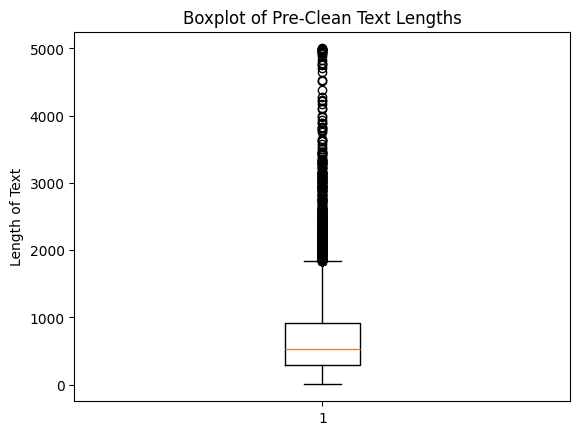

In [156]:
pre_clean_len_list = Philadelphia_reviews['text_length_before_clean'].to_list()

# Create a box plot
plt.boxplot(pre_clean_len_list)
plt.title('Boxplot of Pre-Clean Text Lengths')
plt.ylabel('Length of Text')
plt.show()


## Data Cleaning

## Data Cleaning
### HTML decoding - BeautifulSoup

takes a text input and applies HTML parsing using BeautifulSoup. The BeautifulSoup constructor is called with the input to parse the HTML content and extract the plain text. The decoded text is then stored in a new column named "text_parsed".

### ‘@’mention
remove mentions (user mentions starting with '@') from the "text" column. It takes a text input and uses the re.sub() function to substitute mentions with an empty string. 

### URL links
remove URL links from the "text" column. 

use regular expressions (re.sub()) to find and substitute the URLs with an empty string. This step to exclude URLs which are not relevant to sentiment classification is very importante as it  can introduce noise in the analysis.

### UTF-8 BOM (Byte Order Mark)

encodes the text_value as UTF-8 with a Byte Order Mark (BOM) using the "utf-8-sig" encoding. This step is useful when dealing with text that contains special characters or different encodings. After, the re.sub() function replaces any characters that are not within the ASCII range with a question mark ('?')

### Hashtag / numbers

any character in the 'text' column that is not a letter will be replaced with a space. This can is useful for cleaning up text data and removing characters such as numbers, hashtags, punctuation, and special symbols, leaving only the alphabetical content.

In [157]:
# Define the negation dictionary
negations_dic = {
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
    "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "can not", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
    "mustn't": "must not"
}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [158]:
# Define the cleaning function
def text_cleaner(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')  # Change 'lxml' to 'html.parser'
    souped = soup.get_text()
    
    # Handle BOM removal
    try:
        bom_removed = souped.encode("utf-8-sig")
        bom_removed = bom_removed.decode("utf-8-sig").replace("[^\x00-\x7F]+", "?")
    except:
        bom_removed = souped
    
    # Remove mentions and URLs
    pat1 = r'@[A-Za-z0-9_]+'
    pat2 = r'https?://[^ ]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www\.[^ ]+'
    
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    
    # Handle negations
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], stripped)
    
    # Keep only letters
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    
    # Remove single-letter words and join words
    words = [x for x in re.findall(r'\w+', letters_only) if len(x) > 1]
    
    return " ".join(words).strip()


In [159]:
Philadelphia_reviews['cleaned_text'] = Philadelphia_reviews['text'].apply(text_cleaner)

Philadelphia_reviews[['text', 'cleaned_text']]

/var/folders/mc/n_js9n3s5m19y777fgrpry1w0000gn/T/ipykernel_63082/3637289883.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')  # Change 'lxml' to 'html.parser'


text  \
0      I am now a regular. Pretty much every Saturday...   
1      So a friend and I went to this Pakistani "hole...   
2      I loveeee indian food, but I haven't ventured ...   
3      I've been to this place a few times and while ...   
4      Like other reviewers, I was initially a bit pu...   
...                                                  ...   
10402  This is one of those places you're proud you k...   
10403  This pizza arrived hot & huge!\nOn move-in day...   
10404  Plus:\nno website\nno menu (either online or a...   
10405  This pizza is so good! I have recently discove...   
10406  I just found my new favorite pizza place in Ph...   

                                            cleaned_text  
0      am now regular Pretty much every Saturday pick...  
1      So friend and went to this Pakistani hole in t...  
2      loveeee indian food but have not ventured to m...  
3      ve been to this place few times and while have...  
4      Like other reviewers was initially bit put off...  
...                                                  ...  
10402  This is one of those places you re proud you k...  
10403  This pizza arrived hot huge On move in day Yel...  
10404  Plus no website no menu either online or avail...  
10405  This pizza is so good have recently discovered...  
10406  just found my new favorite pizza place in Phil...  

[10407 rows x 2 columns]

In [160]:
stopWords = [
    "get", "going", "go", "got", "one", "im", "lol", "could", "would", "us", "really", "come", "came", "went",
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "can", "could", "will", "would", "shall", "should", "may", "might",
    "must", "need", "ought", "to", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "just", "don", "should", "now", "d",
    "ll", "m", "o", "re", "ve", "y", "ain", "aren", "couldn", "didn", "doesn", "hadn",
    "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "shan", "shouldn", "wasn",
    "weren", "won", "wouldn"
]

# NLTK stopwords + custom stopwords
stopsWords = set(stopwords.words('english')).union(set(stopWords))


def handle_stopsWords(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text (split into words)
    tokens = text.lower().split()
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stopsWords]
    
    # Join tokens back to form the cleaned text
    return ' '.join(filtered_tokens)

In [161]:
Philadelphia_reviews['cleaned_text_stopwords_removed'] = Philadelphia_reviews['cleaned_text'].apply(handle_stopsWords)
Philadelphia_reviews[['text', 'text_length_before_clean', 'cleaned_text','cleaned_text_stopwords_removed']].head(20)

text  \
0   I am now a regular. Pretty much every Saturday...   
1   So a friend and I went to this Pakistani "hole...   
2   I loveeee indian food, but I haven't ventured ...   
3   I've been to this place a few times and while ...   
4   Like other reviewers, I was initially a bit pu...   
5   I recently discovered this place while driving...   
6   The interior is a tad off putting but don't le...   
7   Eating here is like dining in a 7-11. Horrible...   
8   Dinner was a simple lamb, spicy tomato dish, b...   
9   Disappointed!One star for the people there--fr...   
10  Great chicken korma, naan, samosa had pine nut...   
11  Best (but only) Indian food I've had in the No...   
12  The food at this place is really really really...   
13  Food was fine, nothing too exciting. Service w...   
14  I can only echo the complimentary posts below....   
15  My husband and I aren't into the fancy dining,...   
16  I have been coming to this place for some time...   
17  Went there for the first time yesterday for lu...   
18  Great hole in the wall Indian. My wife and I f...   
19  It's a restaurant within a store. Good food, r...   

    text_length_before_clean  \
0                        174   
1                       1205   
2                        982   
3                        559   
4                        403   
5                        545   
6                        121   
7                        304   
8                        376   
9                        871   
10                       290   
11                       684   
12                       412   
13                       390   
14                      2579   
15                       470   
16                       688   
17                       408   
18                       452   
19                       201   

                                         cleaned_text  \
0   am now regular Pretty much every Saturday pick...   
1   So friend and went to this Pakistani hole in t...   
2   loveeee indian food but have not ventured to m...   
3   ve been to this place few times and while have...   
4   Like other reviewers was initially bit put off...   
5   recently discovered this place while driving t...   
6   The interior is tad off putting but do not let...   
7   Eating here is like dining in Horrible atmosph...   
8   Dinner was simple lamb spicy tomato dish basma...   
9   Disappointed One star for the people there fri...   
10  Great chicken korma naan samosa had pine nuts ...   
11  Best but only Indian food ve had in the Northe...   
12  The food at this place is really really really...   
13  Food was fine nothing too exciting Service was...   
14  can only echo the complimentary posts below Fo...   
15  My husband and are not into the fancy dining b...   
16  have been coming to this place for some time n...   
17  Went there for the first time yesterday for lu...   
18  Great hole in the wall Indian My wife and figu...   
19  It restaurant within store Good food really lo...   

                       cleaned_text_stopwords_removed  
0   regular pretty much every saturday pick two en...  
1   friend pakistani hole wall literally feels lik...  
2   loveeee indian food ventured many indian resta...  
3   place times sampled even half menu yet say sur...  
4   like reviewers initially bit put decor market ...  
5   recently discovered place driving northeast pl...  
6   interior tad putting let discourage food great...  
7   eating like dining horrible atmosphere food pr...  
8   dinner simple lamb spicy tomato dish basmati r...  
9   disappointed star people friendly welcoming re...  
10  great chicken korma naan samosa pine nuts best...  
11  best indian food northeast like many reviews s...  
12  food place good service also good said seating...  
13  food fine nothing exciting service poor called...  
14  echo complimentary posts forget place looks li...  
15  husband fancy dining eating well saw reviews z...  
16  coming place time even o

# Data Preprocessing

In [162]:
# Count the number of occurrences of each sentiment
df_class_pd = Philadelphia_reviews['sentiment'].value_counts().reset_index()
df_class_pd.columns = ['sentiment', 'count']

In [163]:
df_class_pd

sentiment  count
0          1   8780
1          0   1627

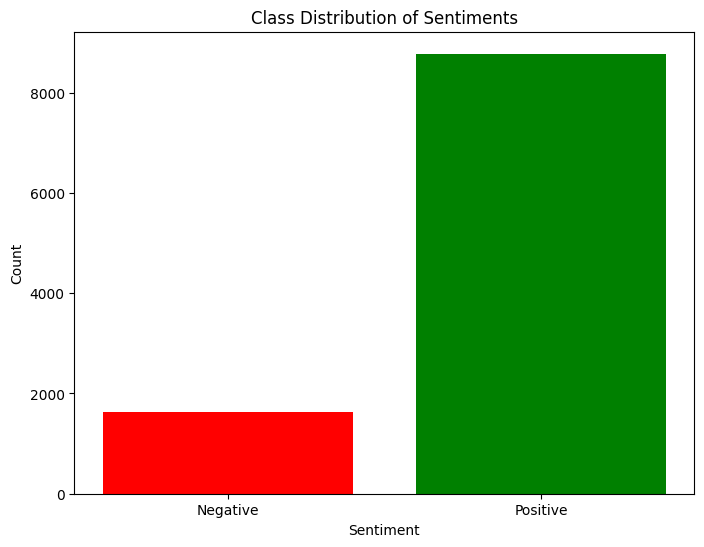

In [164]:
# Create a bar plot
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.bar(df_class_pd['sentiment'], df_class_pd['count'], color=['green', 'red'])

# Set x-ticks to 0 and 1
plt.xticks([0, 1], ['Negative', 'Positive'])  # Adjust the labels as needed

# Set the legend and title of the chart
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Class Distribution of Sentiments')

# Show the plot
plt.show()

In [165]:
words = Philadelphia_reviews['cleaned_text_stopwords_removed'].str.cat(sep=' ').split()
word_counts = pd.Series(words).value_counts()

# Get the top N words
numberWords = 25
top_words = word_counts.head(numberWords)
top_words


good          7668
food          7632
place         6383
great         5150
like          4594
service       3565
time          3513
back          2993
also          2945
delicious     2537
best          2496
chicken       2403
menu          2290
well          2252
restaurant    2237
ordered       2231
cheese        2227
nice          2139
order         2112
philly        2080
little        2065
even          2026
love          2020
try           1940
pretty        1884
Name: count, dtype: int64

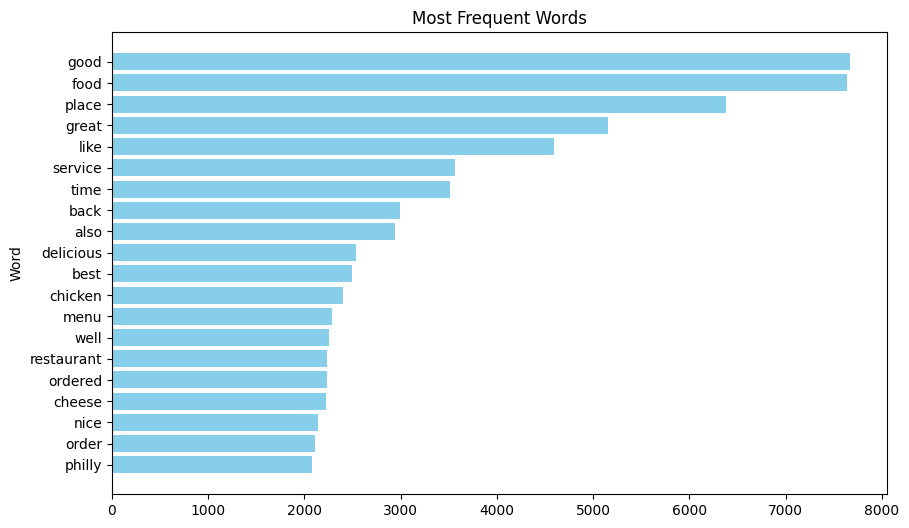

In [166]:
words = Philadelphia_reviews['cleaned_text_stopwords_removed'].str.split(expand=True).stack()
word_counts = words.value_counts().reset_index()
word_counts.columns = ['word', 'count']
word_counts = word_counts.sort_values(by='count', ascending=False)

numberWords = 20
top_words = word_counts.head(numberWords)

plt.figure(figsize=(10, 6))
plt.barh(top_words['word'], top_words['count'], color='skyblue')
plt.ylabel('Word')
plt.title('Most Frequent Words')
plt.gca().invert_yaxis()

plt.show()

## Word Cloud

### Unigram (Ngram = 1)

Text(0.5, 1.0, 'Word Cloud for Unigram')

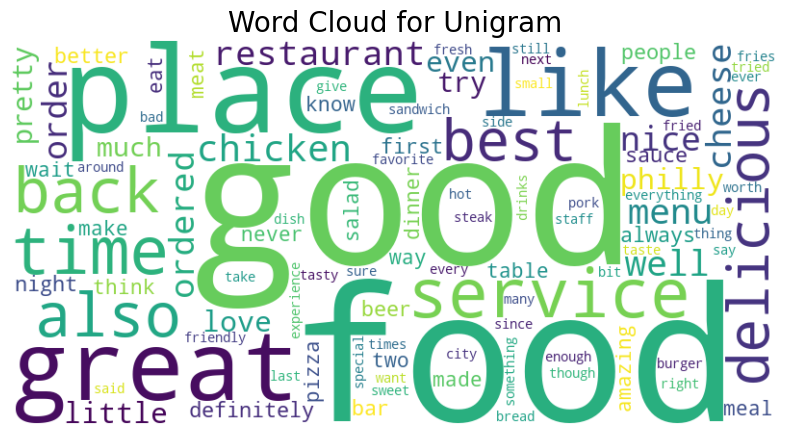

In [167]:
numberWords = 10

# Step 1: Limit the DataFrame to the top N words for the word cloud
wordCounts_pd = word_counts.head(numberWords * 10)

# Step 2: Generate the word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordCounts_pd.set_index('word')['count'].to_dict())

# Step 3: Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Unigram', fontsize=20)


### Bigrams (Ngram = 2)

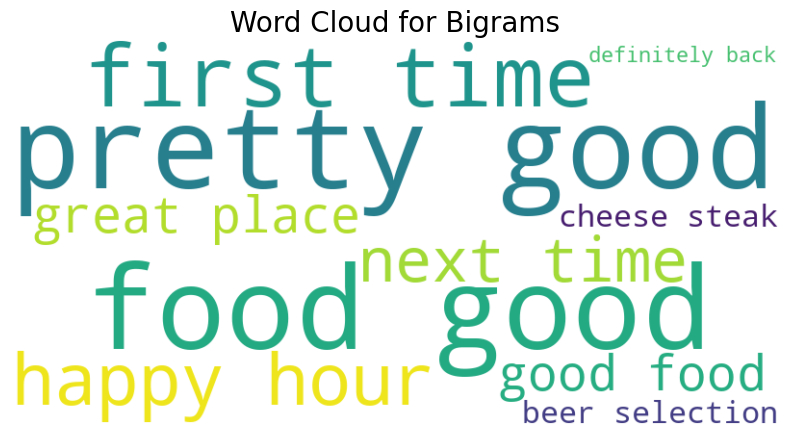

In [168]:
from nltk import bigrams
from collections import Counter

bigram_list = list(bigrams(' '.join(Philadelphia_reviews['cleaned_text_stopwords_removed']).split()))
bigram_counts = Counter(bigram_list)

bigram_counts_df = pd.DataFrame(bigram_counts.items(), columns=['bigram', 'count'])
bigram_counts_df['bigram'] = bigram_counts_df['bigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string
bigram_counts_df = bigram_counts_df.sort_values(by='count', ascending=False)

numberWords = 10
bigramCounts_pd = bigram_counts_df.head(numberWords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigramCounts_pd.set_index('bigram')['count'].to_dict())

# Step 4: Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Bigrams', fontsize=20)
plt.show()

In [169]:
### Trigrams (Ngram = 3)

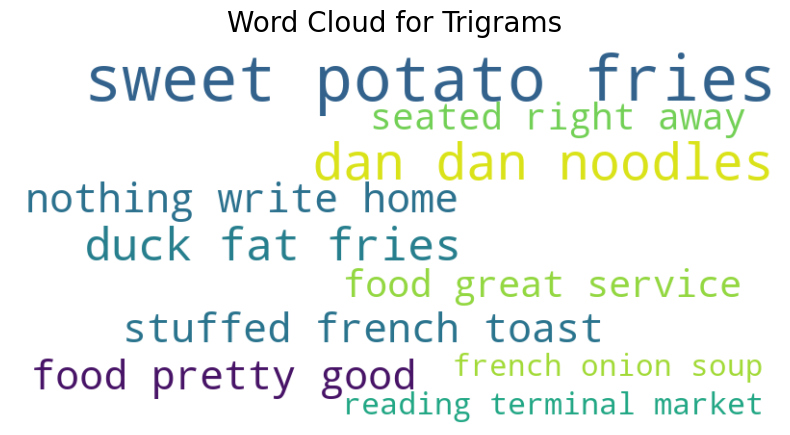

In [170]:
from nltk import trigrams

trigram_list = list(trigrams(' '.join(Philadelphia_reviews['cleaned_text_stopwords_removed']).split()))
trigram_counts = Counter(trigram_list)

trigram_counts_df = pd.DataFrame(trigram_counts.items(), columns=['trigram', 'count'])
trigram_counts_df['trigram'] = trigram_counts_df['trigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string
trigram_counts_df = trigram_counts_df.sort_values(by='count', ascending=False)

numberWords = 10
trigramCounts_pd = trigram_counts_df.head(numberWords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigramCounts_pd.set_index('trigram')['count'].to_dict())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Trigrams', fontsize=20)
plt.show()


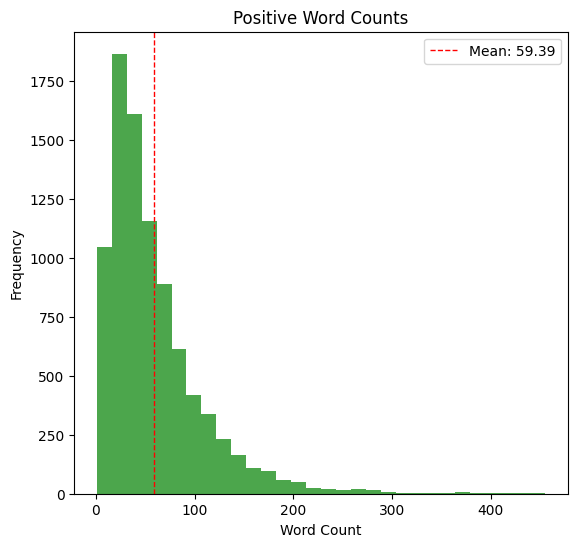

In [171]:
positive_reviews = Philadelphia_reviews[Philadelphia_reviews['sentiment'] == 1]
negative_reviews = Philadelphia_reviews[Philadelphia_reviews['sentiment'] == 0]

# Count words in each review
positive_word_counts = positive_reviews['cleaned_text_stopwords_removed'].str.split().str.len()
negative_word_counts = negative_reviews['cleaned_text_stopwords_removed'].str.split().str.len()

# Calculate means
mean_positive = positive_word_counts.mean()
mean_negative = negative_word_counts.mean()

# Create histograms
plt.figure(figsize=(14, 6))

# Histogram for positive word counts
plt.subplot(1, 2, 1)
plt.hist(positive_word_counts, bins=30, color='green', alpha=0.7)
plt.axvline(mean_positive, color='red', linestyle='dashed', linewidth=1, label='Mean: {:.2f}'.format(mean_positive))
plt.title('Positive Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

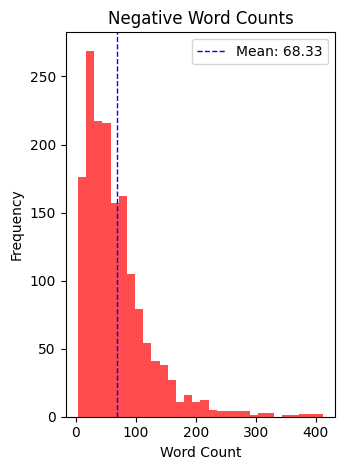

In [172]:
# Histogram for negative word counts
plt.subplot(1, 2, 2)
plt.hist(negative_word_counts, bins=30, color='red', alpha=0.7)
plt.axvline(mean_negative, color='blue', linestyle='dashed', linewidth=1, label='Mean: {:.2f}'.format(mean_negative))
plt.title('Negative Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


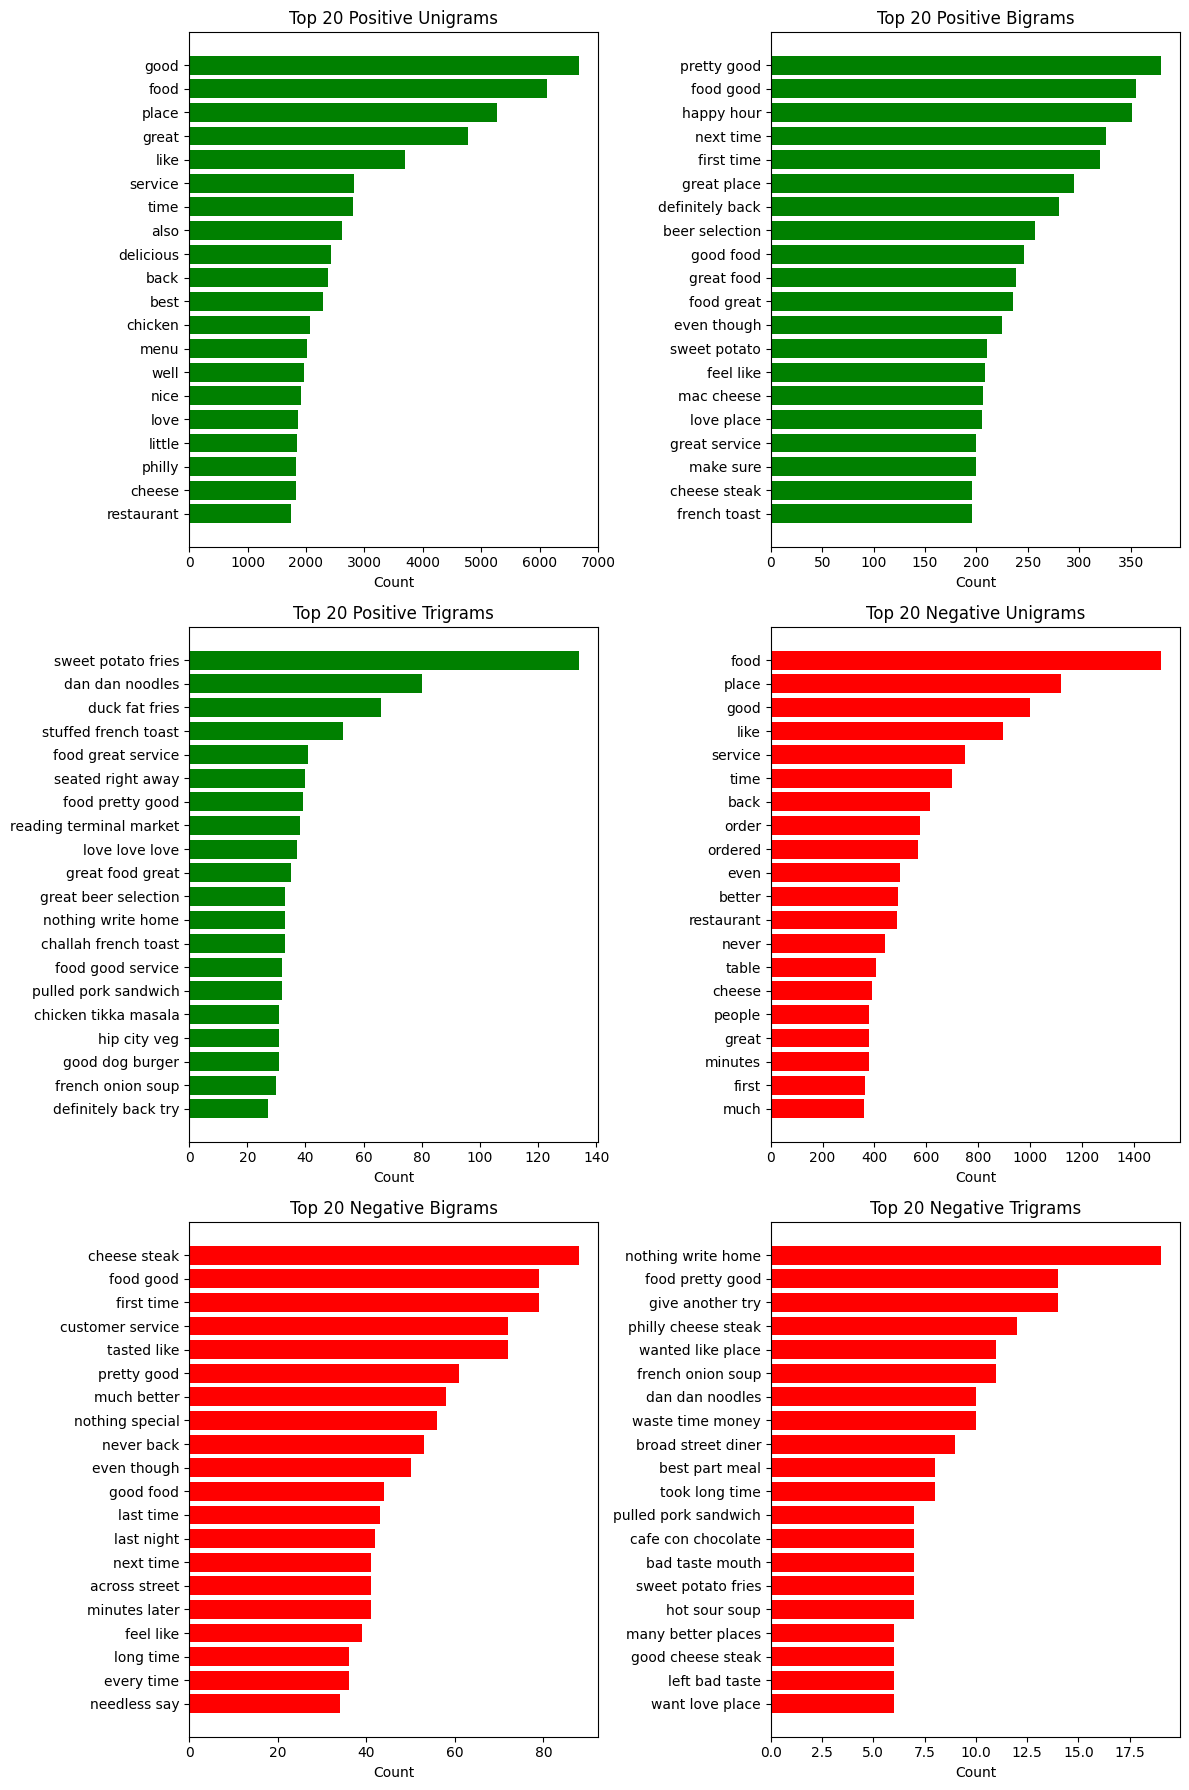

In [173]:
positive_reviews = Philadelphia_reviews[Philadelphia_reviews['sentiment'] == 1]
negative_reviews = Philadelphia_reviews[Philadelphia_reviews['sentiment'] == 0]

# Function to plot top n words/bigrams/trigrams
def plot_top_n(df, n, title, ax, color):
    # Create CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=(n, n))  # Changed to (n, n) to get only n-grams
    X = vectorizer.fit_transform(df['cleaned_text_stopwords_removed'])

    # Sum the counts for each feature
    counts = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    
    # Create DataFrame for visualization
    word_counts = pd.DataFrame({'word': words, 'count': counts})
    word_counts = word_counts[word_counts['count'] > 0]  # Filter out zero counts
    word_counts = word_counts.sort_values(by='count', ascending=False).head(20)

    # Plotting
    ax.barh(word_counts['word'], word_counts['count'], color=color)
    ax.set_title(title)
    ax.set_xlabel('Count')
    ax.invert_yaxis()  # Invert y-axis to have the highest counts at the top

# Create a figure for subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Plot for positive unigrams
plot_top_n(positive_reviews, 1, 'Top 20 Positive Unigrams', axs[0, 0], color='green')
# Plot for positive bigrams
plot_top_n(positive_reviews, 2, 'Top 20 Positive Bigrams', axs[0, 1], color='green')
# Plot for positive trigrams
plot_top_n(positive_reviews, 3, 'Top 20 Positive Trigrams', axs[1, 0], color='green')
# Plot for negative unigrams
plot_top_n(negative_reviews, 1, 'Top 20 Negative Unigrams', axs[1, 1], color='red')
# Plot for negative bigrams
plot_top_n(negative_reviews, 2, 'Top 20 Negative Bigrams', axs[2, 0], color='red')
# Plot for negative trigrams
plot_top_n(negative_reviews, 3, 'Top 20 Negative Trigrams', axs[2, 1], color='red')

# Adjust layout
plt.tight_layout()
plt.show()




# Machine Learning - Sentiment Prediction

**Train-Test Split:** Splits the dataset into training and testing sets.

**TF-IDF Transformation:** Transforms the cleaned text into TF-IDF features.

**Handling Class Imbalance:** Uses SMOTE to oversample the minority class in the training data.

**Model Training:** Trains a Logistic Regression model on the resampled training data.

**Predictions:** Makes predictions on the test set.

**Evaluation:** Prints the confusion matrix and classification report to evaluate the model's performance

In order to predict a rating for an item for an active user, we need to find all weights between the active user and all other users. We then take all non-zero weights and have each other user "vote" on what they think the active user should rate the item. Those with higher weights will matter more in the voting process. Once these votes are tallied, we have a predicted vote.

<b>TF-IDF + Logistic Regression</b>

In [174]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [175]:
Philadelphia_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'restaurant_name', 'address', 'city', 'state',
       'attributes', 'categories', 'latitude', 'longitude', 'is_open', 'year',
       'sentiment', 'text_length_before_clean', 'cleaned_text',
       'cleaned_text_stopwords_removed'],
      dtype='object')

In [192]:
X = Philadelphia_reviews['cleaned_text_stopwords_removed']
y = Philadelphia_reviews['sentiment']

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define a pipeline with TF-IDF and Logistic Regression, applying SMOTE to the training data
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),         
    ('smote', SMOTE(random_state=42)),    
    ('logreg', LogisticRegression())      
])

# Perform stratified k-fold cross-validation (with 5 folds)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and predict
y_train_pred = cross_val_predict(pipeline, X_train, y_train, cv=stratified_kfold)

# Evaluate the model on training set with cross-validation predictions
print("Training Set - Confusion Matrix (Cross-Validation):")
print(confusion_matrix(y_train, y_train_pred))

print("\nTraining Set - Classification Report (Cross-Validation):")
print(classification_report(y_train, y_train_pred))

# Now fit the model on the entire training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_test_pred = pipeline.predict(X_test)
# Get predicted probabilities for the positive class
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model on the test set
print("\nTest Set - Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nTest Set - Classification Report:")
print(classification_report(y_test, y_test_pred))


Training Set - Confusion Matrix (Cross-Validation):
[[ 987  315]
 [ 496 6527]]

Training Set - Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1302
           1       0.95      0.93      0.94      7023

    accuracy                           0.90      8325
   macro avg       0.81      0.84      0.83      8325
weighted avg       0.91      0.90      0.91      8325


Test Set - Confusion Matrix:
[[ 262   63]
 [ 142 1615]]

Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72       325
           1       0.96      0.92      0.94      1757

    accuracy                           0.90      2082
   macro avg       0.81      0.86      0.83      2082
weighted avg       0.91      0.90      0.91      2082



In [193]:
# Calculate evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print additional metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.90
Precision: 0.96
Recall: 0.92
F1 Score: 0.94


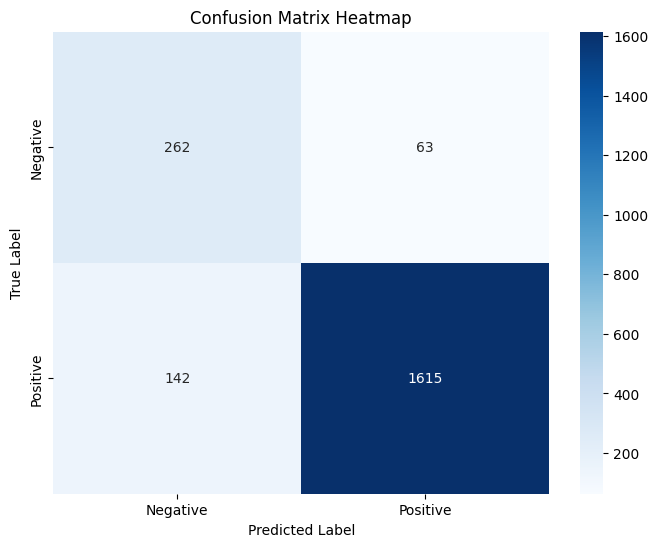

In [195]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

plt.show()

## Undersampling

In [219]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

X = Philadelphia_reviews['cleaned_text_stopwords_removed']
y = Philadelphia_reviews['sentiment']

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define a pipeline with TF-IDF, RandomUnderSampler, and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),                   
    ('undersample', RandomUnderSampler(random_state=42)),  
    ('logreg', LogisticRegression())                
])

# Perform stratified k-fold cross-validation (with 5 folds)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and predict on training data
y_train_pred = cross_val_predict(pipeline, X_train, y_train, cv=stratified_kfold)

# Evaluate the model on training set with cross-validation predictions
print("Training Set - Confusion Matrix (Cross-Validation):")
print(confusion_matrix(y_train, y_train_pred))

print("\nTraining Set - Classification Report (Cross-Validation):")
print(classification_report(y_train, y_train_pred))

# Now fit the model on the entire training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set - Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nTest Set - Classification Report:")
print(classification_report(y_test, y_test_pred))


Training Set - Confusion Matrix (Cross-Validation):
[[1110  192]
 [ 996 6027]]

Training Set - Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.53      0.85      0.65      1302
           1       0.97      0.86      0.91      7023

    accuracy                           0.86      8325
   macro avg       0.75      0.86      0.78      8325
weighted avg       0.90      0.86      0.87      8325


Test Set - Confusion Matrix:
[[ 289   36]
 [ 256 1501]]

Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.89      0.66       325
           1       0.98      0.85      0.91      1757

    accuracy                           0.86      2082
   macro avg       0.75      0.87      0.79      2082
weighted avg       0.91      0.86      0.87      2082



In [220]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Print additional metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.86
Precision: 0.98
Recall: 0.85
F1 Score: 0.91


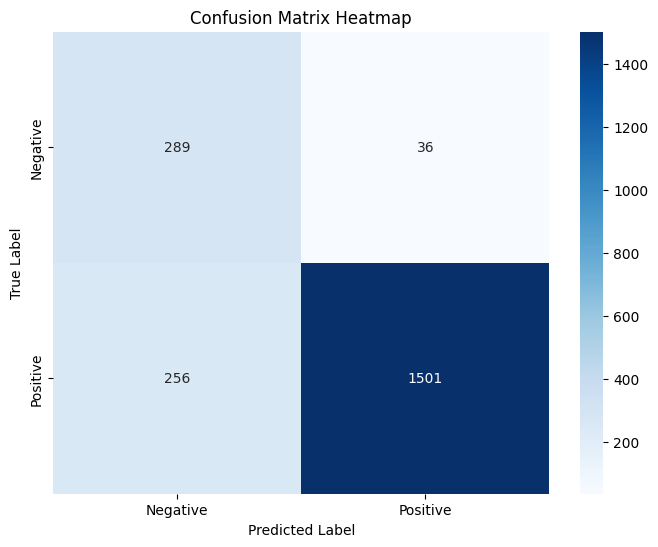

In [221]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

plt.show()

In [ ]:
import seaborn as sns
import sys
sys.path.append("../../")   # to reach the Utils folder
from Utils.utils import precision_at_k,recall_at_k,f1_at_k,average_precision,dcg_at_k

ground_truth = [str(i) for i in np.where(y_test >= 0.5)[0]]  # Indices of positive samples

# Calculate metrics for the top K recommendations
k = 10
recommendations = [str(i) for i in np.argsort(y_pred_proba)[-k:]]  # Top K indices

# Calculate metrics
precision = precision_at_k(recommendations, ground_truth)
recall = recall_at_k(recommendations, ground_truth)
f1_score = f1_at_k(recommendations, ground_truth)
avg_precision = average_precision(recommendations, ground_truth)
dcg_score = dcg_at_k(recommendations, ground_truth)

# Print metrics
print(f"Precision@{k}: {precision}")
print(f"Recall@{k}: {recall}")
print(f"F1 Score@{k}: {f1_score}")
print(f"Average Precision@{k}: {avg_precision}")
print(f"DCG@{k}: {dcg_score}")

In [223]:
Philadelphia_reviews['predicted_sentiment'] = pipeline.predict(Philadelphia_reviews['cleaned_text_stopwords_removed'])

user_item_matrix = Philadelphia_reviews.pivot_table(
    index='user_id',                    # Rows: user IDs
    columns='restaurant_name',           # Columns: restaurant names
    values='predicted_sentiment',        # Values: predicted sentiment
    fill_value=0                         # Fill missing values with 0
)

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity,                     # Cosine similarity values
    index=user_item_matrix.index,         # Row labels: user IDs
    columns=user_item_matrix.index        # Column labels: user IDs
)

user_similarity_df.head()

user_id                 --pMssoWlOqX0pLiPMiZZw  -00kdEIhCt-ODaV4BS-EAg  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                     0.0   
-00kdEIhCt-ODaV4BS-EAg                     0.0                     0.0   
-0aZWYi2YicFaLxTru96nA                     0.0                     0.0   
-2Pn4YRNRgJM8foLYkkv7g                     0.0                     0.0   
-2_eYCiY4JXD_hUI2_HK6w                     0.0                     0.0   

user_id                 -0aZWYi2YicFaLxTru96nA  -2Pn4YRNRgJM8foLYkkv7g  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                     0.0   
-00kdEIhCt-ODaV4BS-EAg                     0.0                     0.0   
-0aZWYi2YicFaLxTru96nA                     1.0                     0.0   
-2Pn4YRNRgJM8foLYkkv7g                     0.0                     1.0   
-2_eYCiY4JXD_hUI2_HK6w                     0.0                     0.0   

user_id                 -2_eYCiY4JXD_hUI2_HK6w  -2cSqxSO-ZHhwezb_H5xaw  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                     0.0   
-00kdEIhCt-ODaV4BS-EAg                     0.0                     0.0   
-0aZWYi2YicFaLxTru96nA                     0.0                     0.0   
-2Pn4YRNRgJM8foLYkkv7g                     0.0                     0.0   
-2_eYCiY4JXD_hUI2_HK6w                     1.0                     0.0   

user_id                 -3GWf7sAkeMgineBaJMLNg  -6ZqxJDnaJM7NPGXge6eqw  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                     0.0   
-00kdEIhCt-ODaV4BS-EAg                     0.0                     0.0   
-0aZWYi2YicFaLxTru96nA                     0.0                     0.0   
-2Pn4YRNRgJM8foLYkkv7g                     0.0                     0.0   
-2_eYCiY4JXD_hUI2_HK6w                     0.0                     0.0   

user_id                 -70L58eedwq9afSufUlpZA  -822bzeF5x6uOKSuTDgabA  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                     0.0   
-00kdEIhCt-ODaV4BS-EAg                     0.0                     0.0   
-0aZWYi2YicFaLxTru96nA                     0.0                     0.0   
-2Pn4YRNRgJM8foLYkkv7g                     0.0                     0.0   
-2_eYCiY4JXD_hUI2_HK6w                     0.0                     0.0   

user_id                 -8EFwVxibpWFCT9sRQt0mw  -8NOuak4Sipn7-zy7Nk5hg  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                 0.00000   
-00kdEIhCt-ODaV4BS-EAg                     0.0                 0.00000   
-0aZWYi2YicFaLxTru96nA                     0.0                 0.00000   
-2Pn4YRNRgJM8foLYkkv7g                     0.0                 0.57735   
-2_eYCiY4JXD_hUI2_HK6w                     0.0                 0.00000   

user_id                 -9AihVqkmNMCkab1RE3uBg  -9da1xk7zgnnfO1uTVYGkA  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                     0.0   
-00kdEIhCt-ODaV4BS-EAg                     0.0                     0.0   
-0aZWYi2YicFaLxTru96nA                     0.0                     0.0   
-2Pn4YRNRgJM8foLYkkv7g                     0.0                     0.0   
-2_eYCiY4JXD_hUI2_HK6w                     0.0                     0.0   

user_id                 -9vcczABGXMaXWjI9600VA  -A8NWVsLSAQX_XTqt4WPmg  \
user_id                                                                  
--pMssoWlOqX0pLiPMiZZw                     0.0                     0.0   
-00kdEIhCt-ODaV4BS-EAg                     0.0                     0.0   
-0aZWYi2YicFaLxTru96nA                     0.0                     0.0 

In [235]:
def get_recommendations(user_id, user_similarity_df, user_item_matrix, top_n=15):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)

    similar_users_items = user_item_matrix.loc[similar_users.index]
    recommended_items = similar_users_items.mean(axis=0).sort_values(ascending=False)

    already_rated = user_item_matrix.loc[user_id]
    recommended_items = recommended_items[~recommended_items.index.isin(already_rated[already_rated > 0].index)]
    
    return recommended_items.head(top_n)

user_id = 'zvq6qxc2IVA08jaUelUMRw'
recommendations = get_recommendations(user_id, user_similarity_df, user_item_matrix)
print("Recommendations for {}: \n{}".format(user_id, recommendations))

Recommendations for zvq6qxc2IVA08jaUelUMRw: 
restaurant_name
Zahav                  0.030595
Amada                  0.029919
HipCityVeg             0.027383
Village Whiskey        0.025355
Parc                   0.024172
Sabrina's Café         0.022904
Federal Donuts         0.021636
Honey's Sit-N-Eat      0.018932
Good Dog Bar           0.018594
Jim's South St         0.016227
Khyber Pass Pub        0.015213
Nom Nom Ramen          0.015128
Tria Cafe Wash West    0.013861
Fogo de Chao           0.013692
Butcher and Singer     0.013185
dtype: float64


<b>GBoost</b>

In [225]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer()),                  
    ('undersample', RandomUnderSampler(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))    # Train a Gradient Boosting model
])

y_train_pred_gb = cross_val_predict(pipeline_gb, X_train, y_train, cv=stratified_kfold)

print("Training Set - Confusion Matrix (Cross-Validation):")
print(confusion_matrix(y_train, y_train_pred_gb))

print("\nTraining Set - Classification Report (Cross-Validation):")
print(classification_report(y_train, y_train_pred_gb))

pipeline_gb.fit(X_train, y_train)
y_test_pred_gb = pipeline_gb.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set - Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_gb))

print("\nTest Set - Classification Report:")
print(classification_report(y_test, y_test_pred_gb))


Training Set - Confusion Matrix (Cross-Validation):
[[1054  248]
 [1470 5553]]

Training Set - Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.42      0.81      0.55      1302
           1       0.96      0.79      0.87      7023

    accuracy                           0.79      8325
   macro avg       0.69      0.80      0.71      8325
weighted avg       0.87      0.79      0.82      8325


Test Set - Confusion Matrix:
[[ 285   40]
 [ 368 1389]]

Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.88      0.58       325
           1       0.97      0.79      0.87      1757

    accuracy                           0.80      2082
   macro avg       0.70      0.83      0.73      2082
weighted avg       0.89      0.80      0.83      2082



In [226]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred_gb)
precision = precision_score(y_test, y_test_pred_gb)
recall = recall_score(y_test, y_test_pred_gb)
f1 = f1_score(y_test, y_test_pred_gb)

# Print additional metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.80
Precision: 0.97
Recall: 0.79
F1 Score: 0.87


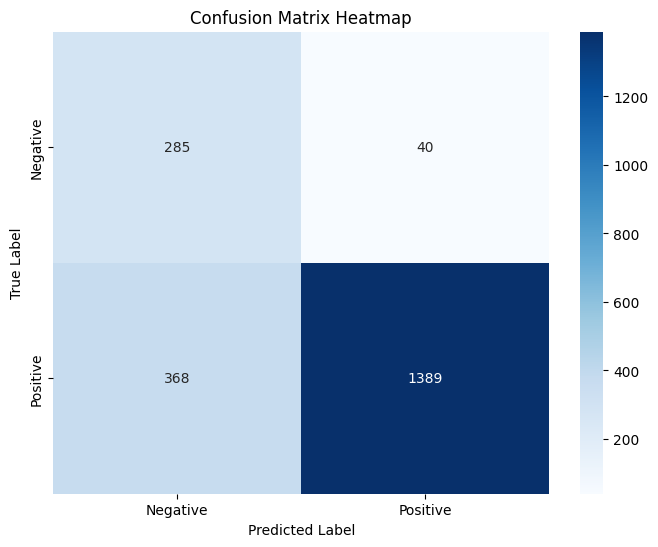

In [227]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

plt.show()

<b>KNN</b>

In [228]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1))),     
    ('undersample', RandomUnderSampler(random_state=42)),  
    ('knn', KNeighborsClassifier(n_neighbors=5))          # Train a KNN model with 5 neighbors
])

y_train_pred_knn = cross_val_predict(pipeline_knn, X_train, y_train, cv=stratified_kfold)

print("KNN Training Set - Confusion Matrix (Cross-Validation):")
print(confusion_matrix(y_train, y_train_pred_knn))

print("\nKNN Training Set - Classification Report (Cross-Validation):")
print(classification_report(y_train, y_train_pred_knn))

pipeline_knn.fit(X_train, y_train)
y_test_pred_knn = pipeline_knn.predict(X_test)

print("\nKNN Test Set - Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_knn))

print("\nKNN Test Set - Classification Report:")
print(classification_report(y_test, y_test_pred_knn))



KNN Training Set - Confusion Matrix (Cross-Validation):
[[ 924  378]
 [2029 4994]]

KNN Training Set - Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.31      0.71      0.43      1302
           1       0.93      0.71      0.81      7023

    accuracy                           0.71      8325
   macro avg       0.62      0.71      0.62      8325
weighted avg       0.83      0.71      0.75      8325


KNN Test Set - Confusion Matrix:
[[ 231   94]
 [ 500 1257]]

KNN Test Set - Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.71      0.44       325
           1       0.93      0.72      0.81      1757

    accuracy                           0.71      2082
   macro avg       0.62      0.71      0.62      2082
weighted avg       0.83      0.71      0.75      2082



In [229]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred_knn)
precision = precision_score(y_test, y_test_pred_knn)
recall = recall_score(y_test, y_test_pred_knn)
f1 = f1_score(y_test, y_test_pred_knn)

# Print additional metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.71
Precision: 0.93
Recall: 0.72
F1 Score: 0.81


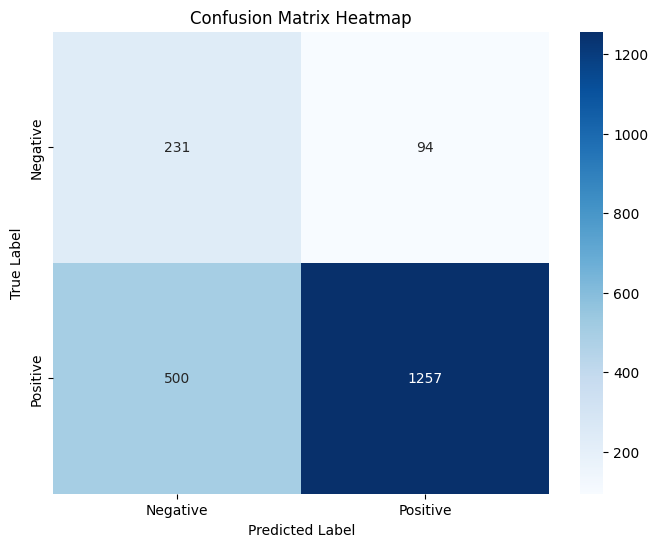

In [230]:
cm = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

plt.show()

### Ngram

### Trigrams

In [231]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(3, 3))),      # Convert text to TF-IDF with trigrams
    ('undersample', RandomUnderSampler(random_state=42)),  # Handle imbalanced data using undersampling
    ('logreg', LogisticRegression(max_iter=1000))         # Train a logistic regression model
])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_train_pred_lr = cross_val_predict(pipeline_lr, X_train, y_train, cv=stratified_kfold)

print("Training Set - Confusion Matrix (Cross-Validation):")
print(confusion_matrix(y_train, y_train_pred_lr))

print("\nTraining Set - Classification Report (Cross-Validation):")
print(classification_report(y_train, y_train_pred_lr))

pipeline_lr.fit(X_train, y_train)
y_test_pred_lr = pipeline_lr.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred_lr)
precision = precision_score(y_test, y_test_pred_lr)
recall = recall_score(y_test, y_test_pred_lr)
f1 = f1_score(y_test, y_test_pred_lr)

Training Set - Confusion Matrix (Cross-Validation):
[[ 781  521]
 [2491 4532]]

Training Set - Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.24      0.60      0.34      1302
           1       0.90      0.65      0.75      7023

    accuracy                           0.64      8325
   macro avg       0.57      0.62      0.55      8325
weighted avg       0.79      0.64      0.69      8325



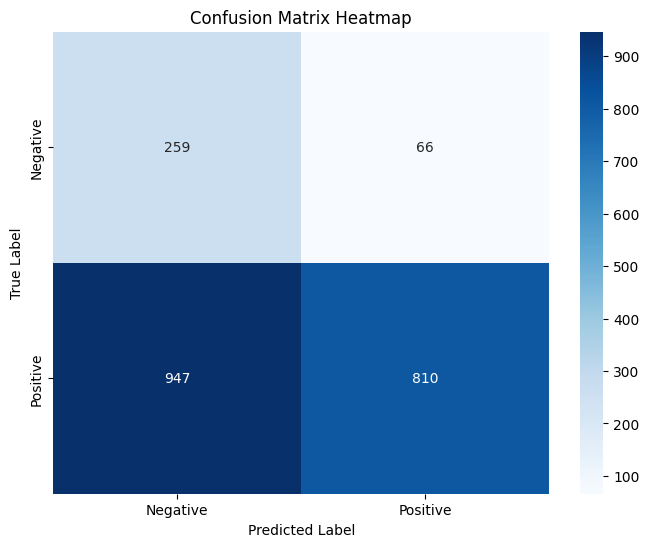

In [232]:
cm = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

plt.show()

### Bigrams

In [233]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(2, 2))),      # Convert text to TF-IDF with bigrams
    ('undersample', RandomUnderSampler(random_state=42)),  # Handle imbalanced data using undersampling
    ('logreg', LogisticRegression(max_iter=1000))         # Train a logistic regression model
])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_train_pred_lr = cross_val_predict(pipeline_lr, X_train, y_train, cv=stratified_kfold)

print("Training Set - Confusion Matrix (Cross-Validation):")
print(confusion_matrix(y_train, y_train_pred_lr))

print("\nTraining Set - Classification Report (Cross-Validation):")
print(classification_report(y_train, y_train_pred_lr))

pipeline_lr.fit(X_train, y_train)
y_test_pred_lr = pipeline_lr.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred_lr)
precision = precision_score(y_test, y_test_pred_lr)
recall = recall_score(y_test, y_test_pred_lr)
f1 = f1_score(y_test, y_test_pred_lr)



Training Set - Confusion Matrix (Cross-Validation):
[[ 979  323]
 [1428 5595]]

Training Set - Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.41      0.75      0.53      1302
           1       0.95      0.80      0.86      7023

    accuracy                           0.79      8325
   macro avg       0.68      0.77      0.70      8325
weighted avg       0.86      0.79      0.81      8325



In [ ]:
import seaborn as sns
import sys
sys.path.append("../../")   # to reach the Utils folder
from Utils.utils import precision_at_k,recall_at_k,f1_at_k,average_precision,dcg_at_k

ground_truth = [str(i) for i in np.where(y_test == 1)[0]]  # Indices of positive samples

# Calculate metrics for the top K recommendations
k = 15
recommendations = [str(i) for i in np.argsort(y_pred_proba)[-k:]]  # Top K indices

# Calculate metrics
precision = precision_at_k(recommendations, ground_truth)
recall = recall_at_k(recommendations, ground_truth)
f1_score = f1_at_k(recommendations, ground_truth)
avg_precision = average_precision(recommendations, ground_truth)
dcg_score = dcg_at_k(recommendations, ground_truth)

# Print metrics
print(f"Precision@{k}: {precision}")
print(f"Recall@{k}: {recall}")
print(f"F1 Score@{k}: {f1_score}")
print(f"Average Precision@{k}: {avg_precision}")
print(f"DCG@{k}: {dcg_score}")

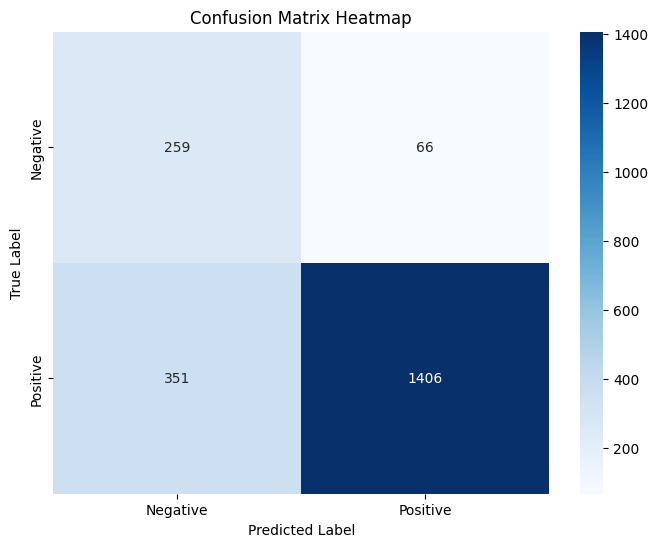

In [234]:
cm = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

plt.show()